## Import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
print(train.shape, test.shape)

(1458644, 11) (625134, 9)


## Exploratory Data Analysis

#### Convert to appropriate data type

Convert pickup datetime and dropoff datetime into date-time object

In [ ]:
train.dtypes

id                    object 
vendor_id             int64  
pickup_datetime       object 
dropoff_datetime      object 
passenger_count       int64  
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag    object 
trip_duration         int64  
dtype: object

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### Are there any missing values in the data?

In [ ]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing values

#### What is the time period of the dataset?

In [ ]:
print("Min pickup time: ", min(train['pickup_datetime']))
print("Max pickup time: ", max(train['pickup_datetime']))

Min pickup time:  2016-01-01 00:00:17
Max pickup time:  2016-06-30 23:59:39


The data has 6 months of taxi trip data, from Jan to Jun 2016.

#### Create new day, month, hour info from pickup time

In [ ]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

#### Round lat lng to 3 decimal places

In [ ]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x:round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x:round(x, 3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x:round(x, 3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x:round(x, 3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


#### Based on Latitude and Longitude get the distance of the trip in km

This uses Haversine Distance

$$ a = sin²(Δφ / 2) + cos φ₁ ⋅ cos φ₂ ⋅ sin²(Δλ / 2)$$

$$c = 2 ⋅ atan2(√a, √(1−a))$$

$$d = R ⋅ c$$

$φ$ : latitude

$λ$ : longitude

In [ ]:
def calculateDistance(row):
  R = 6373.0 # approximate radius of earth in km
  pickup_lat = radians(row['pickup_latitude'])
  pickup_lon = radians(row['pickup_longitude'])
  dropoff_lat = radians(row['dropoff_latitude'])
  dropoff_lon = radians(row['dropoff_longitude'])
  dlon = dropoff_lon - pickup_lon
  dlat = dropoff_lat - pickup_lat
  a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  distance = R * c
  return distance

In [ ]:
train['trip_distance'] = train.apply(lambda row:calculateDistance(row), axis = 1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [ ]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x: x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


#### Exploratory Analysis

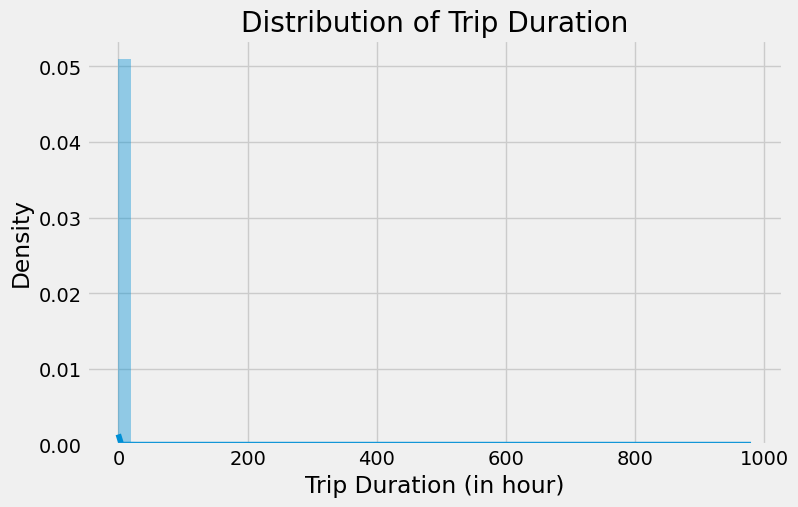

In [ ]:
plt.figure(figsize = (8, 5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")
plt.show()

There are trip duration greater than 24 hours. We will have to investigate this.

In [ ]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


There are 4 records which have very high trip duration, but the distance traveled is very low. These are outliers. But is there any particular location to which these trips begin or end? Trip duration is also skewed, so let us take log transformation.

We will not remove these from the analysis, because they might be a part of test data as well.

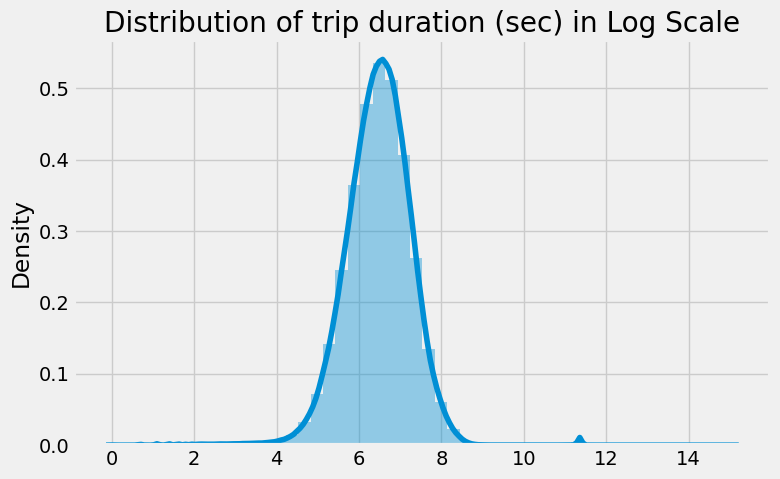

In [ ]:
plt.figure(figsize = (8, 5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")
plt.show()

Log transformation of the trip duration results in a normal distribution. Most trips are between 54 sec (exp(4)) and 2980 sec(exp(8)). This indicates that most trip are withing one hour. But, there are trips which are less than a minute and need to be explored in detail. There are trips lasting for 100 hours which is weird as the taxi rides are whithin New York.

#### Heatmap of common locations from where pickup and dropoff occurs

In [ ]:
pickup = pd.DataFrame(train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count()).reset_index().rename(columns = {'id':'Num_Trips'})

In [ ]:
pickup = pickup.astype({'Num_Trips':'float'})

In [ ]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10)

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1
                 )
pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

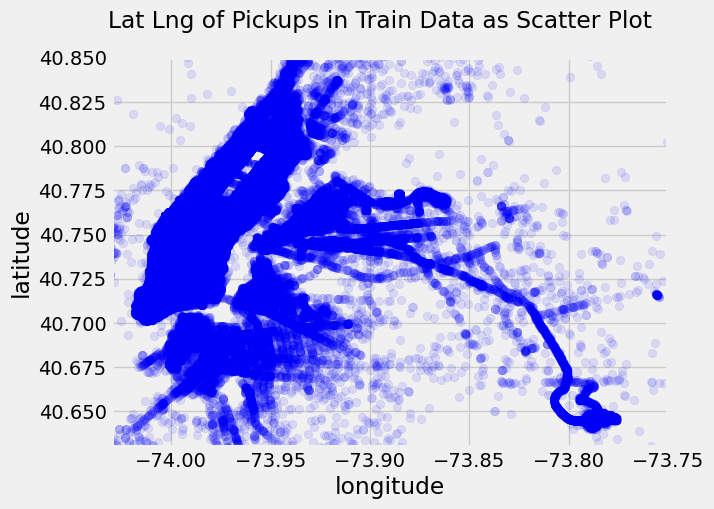

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color = 'blue', label = 'train', alpha = 0.1)
fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

***This graph clearly shows heavy density of pickups near JFK.***

In [ ]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [ ]:
drop = drop.astype({'Num_Trips': 'float'})

In [ ]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1
                 )
drop_map.add_child(hm_wide)
drop_map

#### Heatmap of trip duration, when pickup originates from a point

In [ ]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration': 'Avg_Trip_duration'})

In [ ]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1
                 )
pickup_map.add_child(hm_wide)
pickup_map

The average trip duration, when trip originates from JFK is higher. If we zoom in, we can see that after the Manhattan. The pickups from JFK tend to have higher trip duration.

#### Which hours are pickup and dropoff higher?

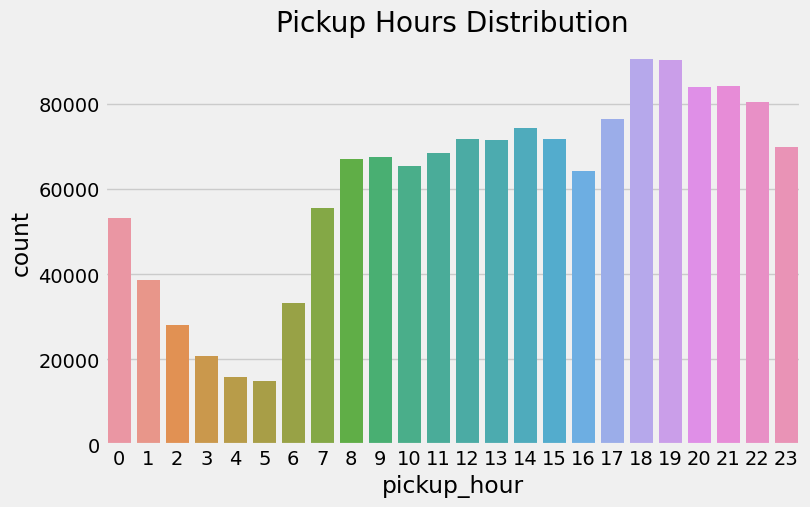

In [ ]:
plt.figure(figsize = (8, 5))
sns.countplot(x = train['pickup_hour']).set_title('Pickup Hours Distribution')
plt.show()

The pickups are much lower in the early mornings. Most pickips are around highest between 6 to 8pm.

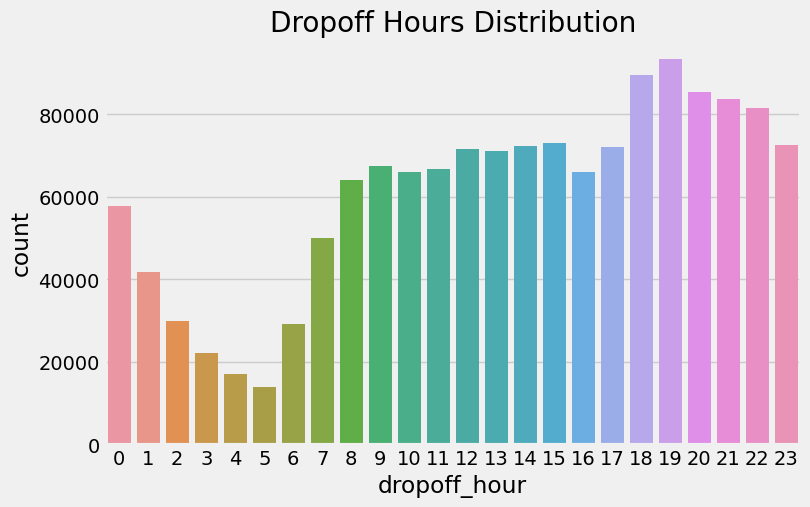

In [ ]:
plt.figure(figsize = (8,5))
sns.countplot(x = train['dropoff_hour']).set_title("Dropoff Hours Distribution")
plt.show()

Distribution of dropoff hour very similar to pickup hour.

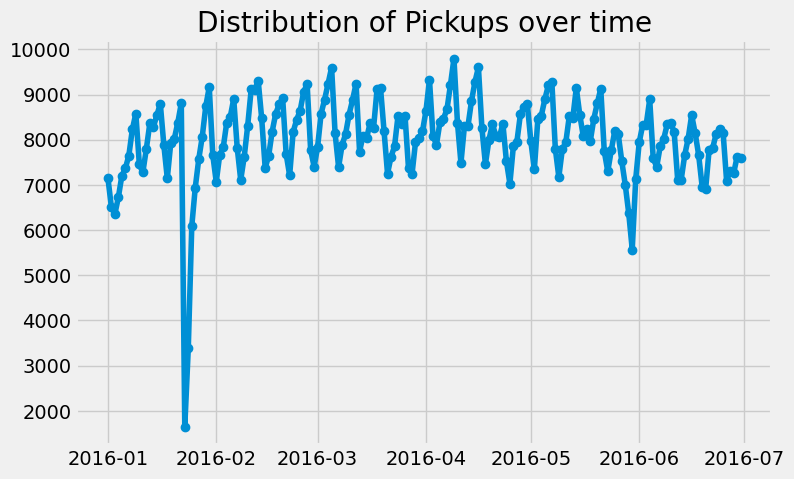

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label = 'train')
plt.title("Distribution of Pickups over time")
plt.show()

There is a drop seen in the number of pick ups in end the January 2016.

#### What is the distribution of Trip distance

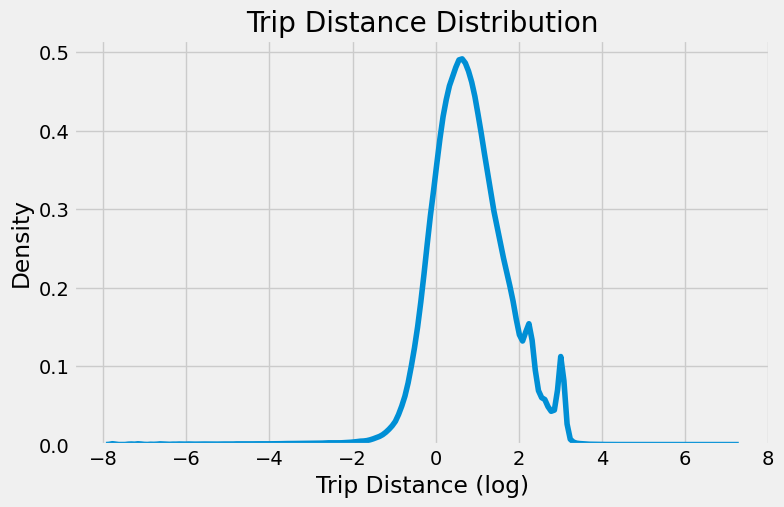

In [ ]:
plt.figure(figsize = (8, 5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

plt.show()

#### Trip Duration vs Trip Distance

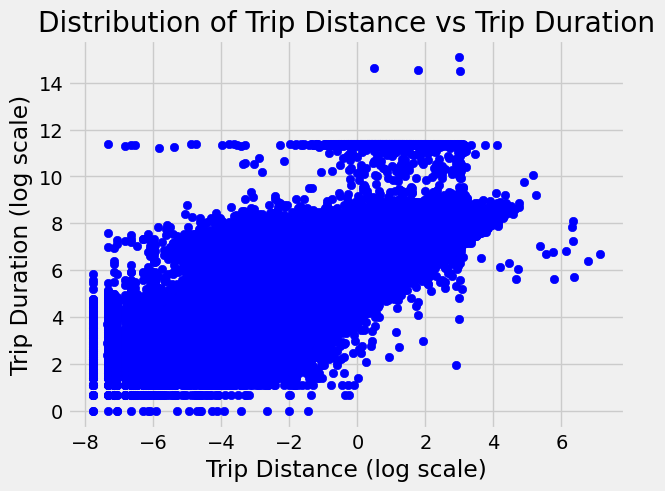

In [ ]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values), color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")
plt.show()

#### Is the trip duration higher at different hours?

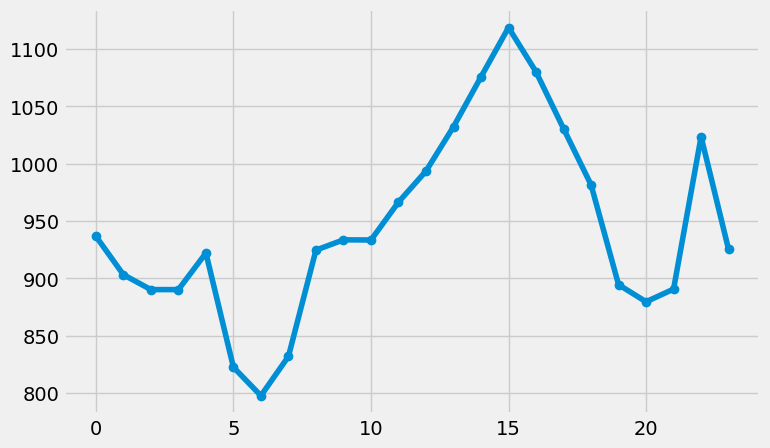

In [ ]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration': 'avg_trip_duration'})
plt.figure(figsize = (8, 5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')
plt.show()

Trip duration increases between 10 to 15 hours.

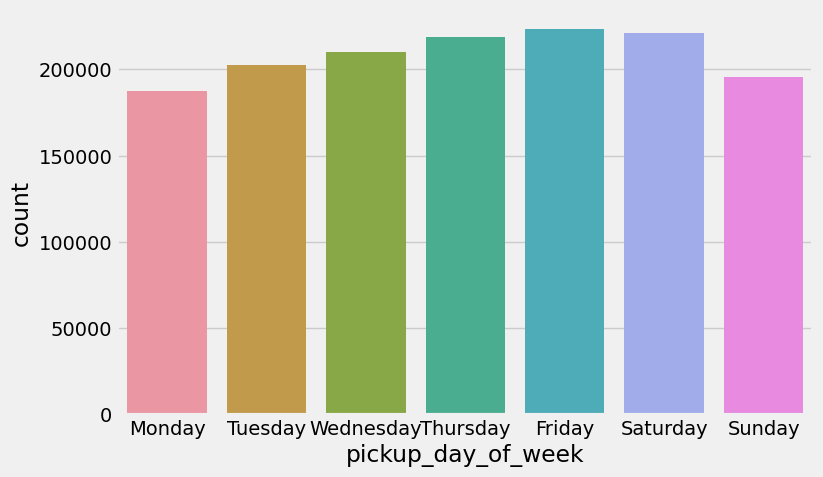

In [ ]:
plt.figure(figsize = (8, 5))
sns.countplot(x = 'pickup_day_of_week', data = train ,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
plt.show()

The number of pickups are very low on Monday. From Tuesday to Friday the number of pickups keep increasing.

#### Avg Trip Duration over Day of week

In [ ]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration':'avg_trip_duration'})

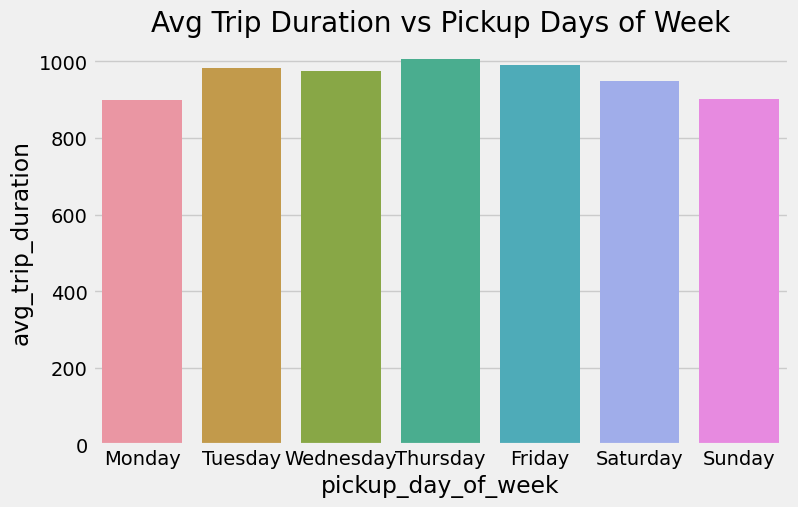

In [ ]:
plt.figure(figsize = (8, 5))
sns.barplot(x = 'pickup_day_of_week', y = 'avg_trip_duration',
            data = avg_duration_day, order = ['Monday','Tuesday',
            'Wednesday','Thursday','Friday','Saturday',
            'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")
plt.show()

The highest average trip duration is on Thursday.

#### Create a calculated field Bearing

Bearing measures the direction of travel The formula is : <br>

$\theta = arctan2(sin𝛥 \lambda * cos \phi2, cos \phi1 * sin \phi2 - sin\phi1 * cos \phi2 * cos 𝛥 \lambda)$ <br>

$\phi$ is the latitude,  $\lambda$ is the longitude.

In [ ]:
def calculateBearing(lat1, lng1, lat2, lng2):
  R = 6371
  lng_delta_rad = np.radians(lng2 - lng1)
  lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
  y = np.sin(lng_delta_rad) * np.cos(lat2)
  x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
  return np.degrees(np.arctan2(y, x))

In [ ]:
train['bearing'] = train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],
                              row['pickup_longitude_round3'],
                              row['dropoff_latitude_round3'],
                              row['dropoff_longitude_round3']), axis = 1)

#### Distribution of Bearing

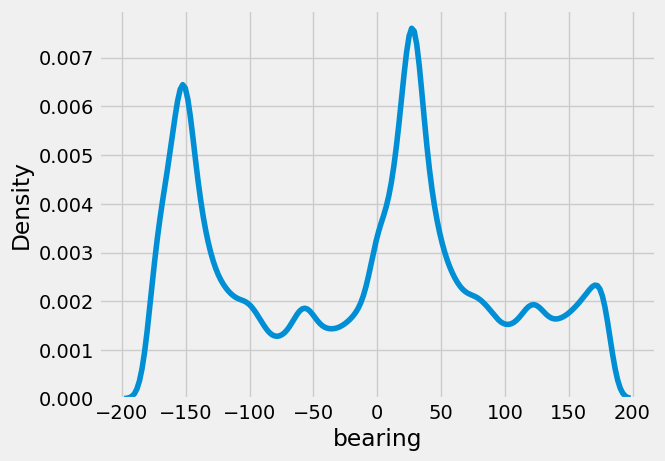

In [ ]:
sns.kdeplot(train['bearing'])
plt.show()

#### Bearing vs Trip Duration

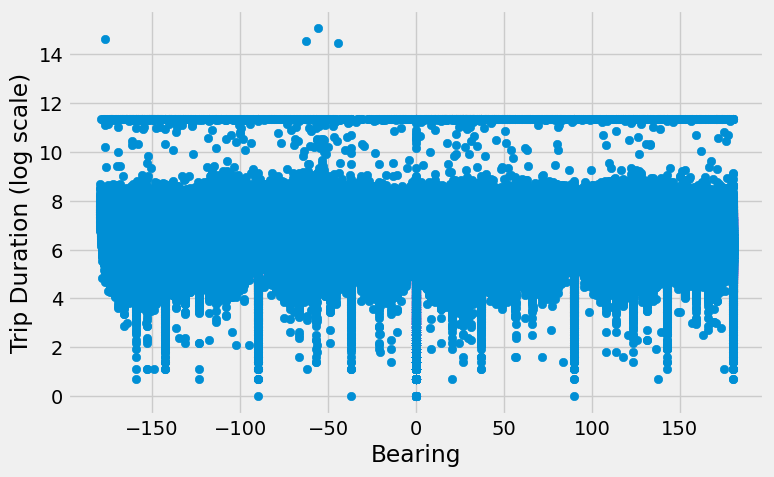

In [ ]:
plt.figure(figsize = (8, 5))
plt.scatter(train['bearing'].values, y = np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")
plt.show()

The outliers in trip duration are all around bearing -50 degrees.

#### Distribution of Store and FWD Flag

In [ ]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

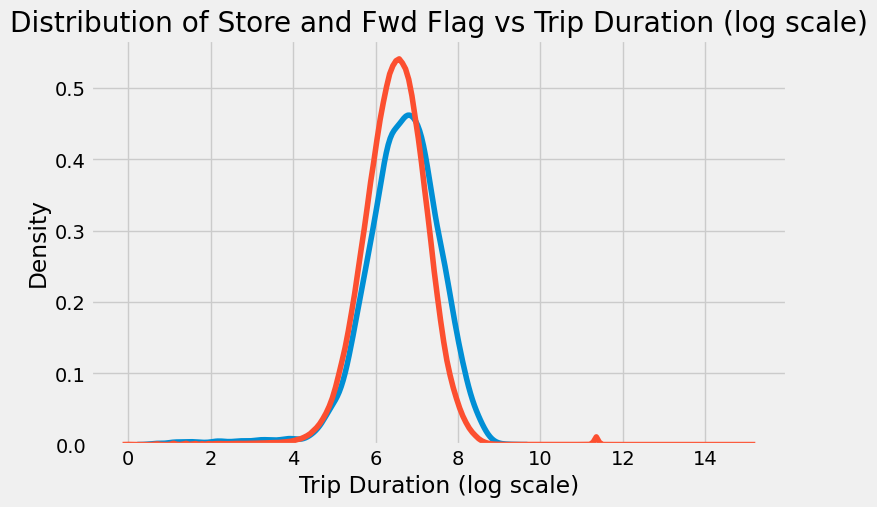

In [ ]:
plt.figure(figsize = (8, 5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'Y', 'trip_duration'].values), label = 'Store and Fwd = Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'N', 'trip_duration'].values), label = 'Store and Fwd = No')

plt.title("Distribution of Store and Fwd Flag vs Trip Duration (log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')
plt.show()

#### Group Locations into cluster

This will help creating neighborhoods. And pickups from certain neighborhoods may have a longer trip duration.

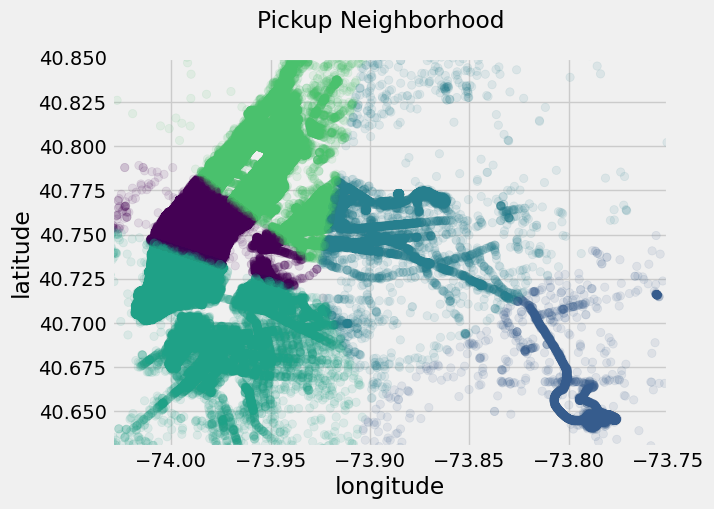

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighborhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighborhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              c=train['pickup_neighborhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighborhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

plt.show()

#### Number of pickups in each neighborhood

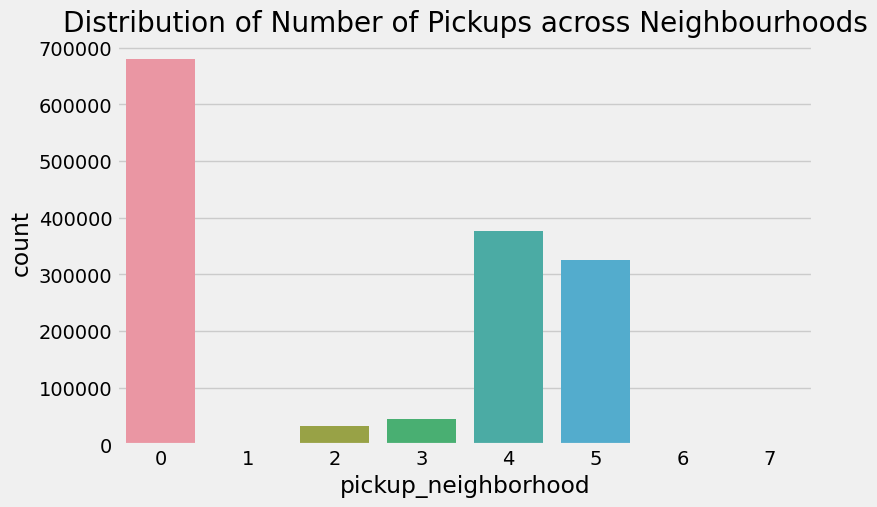

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x = 'pickup_neighborhood', data = train).set_title("Distribution of Number of Pickups across Neighbourhoods")
plt.show()

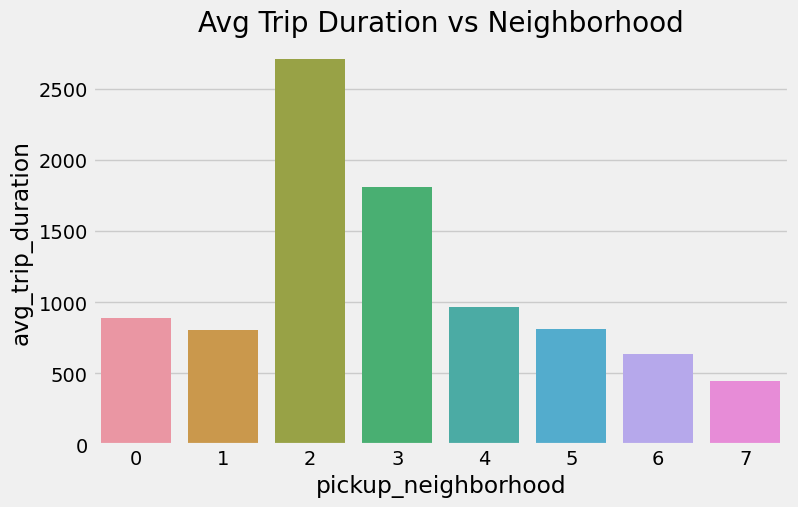

In [ ]:
avg_duration_neighborhood = train.groupby(['pickup_neighborhood'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration':'avg_trip_duration'})
plt.figure(figsize = (8 ,5))
sns.barplot(x = 'pickup_neighborhood', y = 'avg_trip_duration', data = avg_duration_neighborhood).set_title('Avg Trip Duration vs Neighborhood')
plt.show()

Neighborhood 2 has very high average Trip duration, though Neighborhood 0 has majority of pickups.

#### Distribution of Average speed

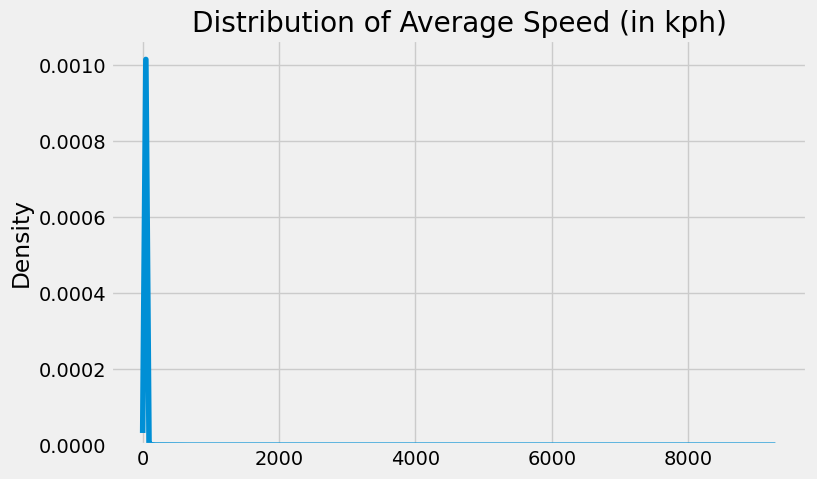

In [ ]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
plt.figure(figsize = (8, 5))
sns.kdeplot(train['avg_speed_kph'].values).set_title('Distribution of Average Speed (in kph)')
plt.show()

In [ ]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph")
#The average speed is 14 kmph

Average speed is 14.427736738459107 kph


#### Average Speed across days of week - this is indication of traffic speed

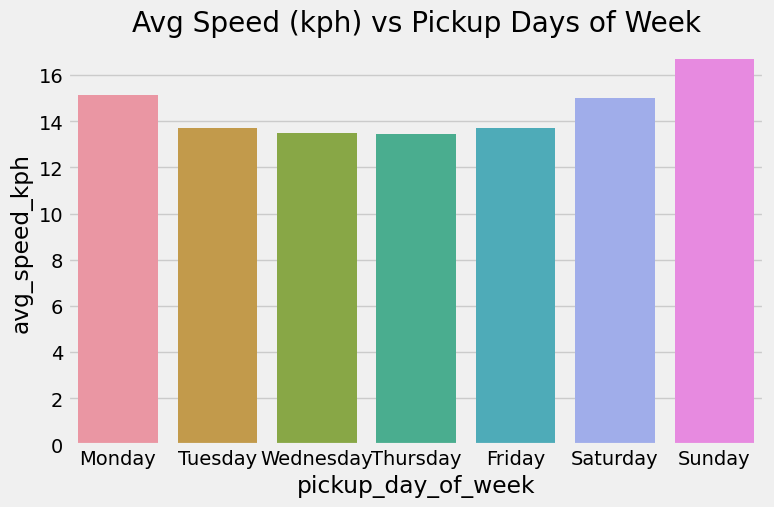

In [ ]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize= (8, 5))
sns.barplot(x = 'pickup_day_of_week', y = 'avg_speed_kph', data = avg_speed_per_day, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")
plt.show()

The average speed is higher on sunday monday.

## Feature Engineering on Test Data

In [ ]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighborhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighborhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

## Building Models

From the training data we need to drop "dropoff datatime features". We also only keep latitude longitude rounded to 3 decimal places.

In [ ]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

We have to predict trip_duration. We will convert this to log scale and predict.


In [ ]:
training['log_trip_duration']=training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'],axis=1,inplace=True)

In [ ]:
print("Training Data Shape ", training.shape)
print("Testing Data Shape ", testing.shape)

Training Data Shape  (1458644, 18)
Testing Data Shape  (625134, 17)


Let us also encode day of week as numbers.

In [ ]:
def encodeDays(day_of_week):
  day_dict = {'Sunday' : 0, 'Monday' : 1, 'Tuesday': 2, 'Wednesday' : 3,
              'Thursday': 4, 'Friday': 5, 'Saturday': 6}
  return day_dict[day_of_week]

In [ ]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [ ]:
training.to_csv("input_training.csv", index = False)
testing.to_csv("input_testing.csv", index = False)
del training
del testing
del train
del test

In [ ]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]

def readInputAndEncode(input_path,train_file,test_file,target_column):
    training=pd.read_csv(input_path+train_file)
    testing=pd.read_csv(input_path+test_file)

    training,testing=LabelEncoding(training,testing)

    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols=training.columns.tolist()
    test_cols=testing.columns.tolist()
    col_in_train_not_test=set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col]=0
    col_in_test_not_train=set(test_cols)-set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training, testing]

In [ ]:
train,test=readInputAndEncode("",'input_training.csv','input_testing.csv','log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)
test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


In [ ]:
def GetFeaturesAndSplit(train, test, target, imputing_strategy = 'median', split = 0.25, imputation = True):
  labels = np.array(train[target])
  training = train.drop(target, axis = 1)
  training = np.array(training)
  testing = np.array(test)
  if imputation == True:
    imputer = SimpleImputer(strategy = imputing_strategy, missing_values = np.nan)
    imputer.fit(training)
    training = imputer.transform(training)
    testing = imputer.transform(testing)
  train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
  return [train_features, validation_features, train_labels, validation_labels, testing]

In [ ]:
train_features, validation_features, train_labels, validation_labels, testing = GetFeaturesAndSplit(train, test, 'log_trip_duration', imputation = False)

#### Apply Linear Regression

In [ ]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression()

In [ ]:
valid_pred = lm.predict(validation_features)

In [ ]:
rmse = mean_squared_error(validation_labels, valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ", rmse)

Root Mean Squared Error for Linear Regression(log scale)  0.4031176249688163


#### Apply Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [ ]:
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [ ]:
valid_pred_rf = rf.predict(validation_features)
rmse = mean_squared_error(validation_labels, valid_pred_rf)
print("Root Mean Squared Error for Random Forest ", rmse)

Root Mean Squared Error for Random Forest  0.16585976592912732
